# Mapping new data to the Human Neural Organoid Cell Atlas (HNOCA)

We built the HNOCA as a comprehensive collection of (healthy) neural organoid datasets. One can view it as a baseline of how neural organoids can "look like" and therefore it can be very valuable to compare new experimental data, e.g. from disease models to the HNOCA. Moreover, we highly encourage  the community to help further expand the atlas over time and submit new datasets to be inclued. 

Here we'll show how you can map new data to the HNOCA and how to perform quantitative comparisons. Analogous to our analysis in the manuscript, we map scRNA-seq data from a brain organoid model of fragile X syndrome and then perform DE analysis. First, let's load all the necessary libraries and the HNOCA data.

In [ ]:
import os
import scarches
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import hnoca.map as hmap
import hnoca.stats as stats

os.chdir("/home/fleckj/scratch/hnoca/")

In [2]:
# Read reference and query data
hnoca_adata = sc.read("HNOCA_hv3k.h5ad")
query_adata = sc.read("KangWen2021_FXS.h5ad")

# Format batch columns
query_adata.obs["batch"] = query_adata.obs["sample"].astype(str).copy()

# Load reference model
hnoca_model = scarches.models.scPoli.load(
    "scpoli_HNOCA/",
    adata=hnoca_adata,
)
print(hnoca_model)

AnnData object with n_obs × n_vars = 1751568 × 3000
    obs: 'assay_sc', 'assay_differentiation', 'assay_type_differentiation', 'bio_sample', 'cell_line', 'cell_type', 'development_stage', 'disease', 'ethnicity', 'gm', 'id', 'individual', 'organ', 'organism', 'sex', 'state_exact', 'sample_source', 'source_doi', 'suspension_type_original', 'tech_sample', 'treatment', 'assay_sc_original', 'cell_line_original', 'cell_type_original', 'development_stage_original', 'disease_original', 'ethnicity_original', 'organ_original', 'organism_original', 'sex_original', 'suspension_type', 'obs_names_original', 'organoid_age_days', 'batch', 'publication', 'doi', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'log_n_genes_by_counts', 'log1p_pct_counts_mt', 'leiden_1', 'leiden_10', 'leiden_pca_1', 'leiden_pca_10', 'leiden_20', 'leiden_80', 'leiden_pca_20', 'leiden_pca_80', 'snap_clusters', 'snap_clusters

Now we have eveything together to start the reference mapping. Here we are finetuning the HNOCA scPoli model for 30 epochs (`n_epochs`) retraining only the weights for the new batch covariates (`retrain="partial"`). 

In [ ]:
mapper = hmap.AtlasMapper(hnoca_model)
mapper.map_query(
    query_adata, 
    retrain='partial',
    n_epochs=30, 
    pretraining_epochs=20, 
    eta=10,
    batch_size=1024
)
mapper.save("HNOCA_FXS_mapper/")

With this finetuned model we can then compute a weighted kNN graph between the query and reference data.

In [ ]:
mapper = hmap.AtlasMapper.load("HNOCA_FXS_mapper/")

In [ ]:
mapper.compute_wknn(k=100)

Using the wkNN graph, we can now transfer cell type labels from the HNOCA to the query data and compute a UMAP from the latent space of the scPoli model.

In [6]:
ct_transfer = mapper.transfer_labels(label_key="level_1_pca")
ct_transfer[["best_label", "best_score"]]

,best_label,best_score
AAACCCACAGTTCCAA.4,neural_progenitor_cell,0.831662
AAACCCAGTTGCATCA.4,neural_progenitor_cell,1.733664
AAACCCAGTTGCATTG.4,neural_progenitor_cell,2.297948
AAACCCATCCACGTGG.4,neuron,1.610558
AAACGAACACAGTGAG.4,neuron,0.854941
...,...,...
TTTGGTTGTCACCCTT.12,choroid_plexus_epithelium,1.629327
TTTGTTGAGACCTTTG.12,choroid_plexus_epithelium,0.321833
TTTGTTGAGGGATGTC.12,neural_progenitor_cell,1.303548
TTTGTTGCAATATCCG.12,neural_progenitor_cell,0.817161


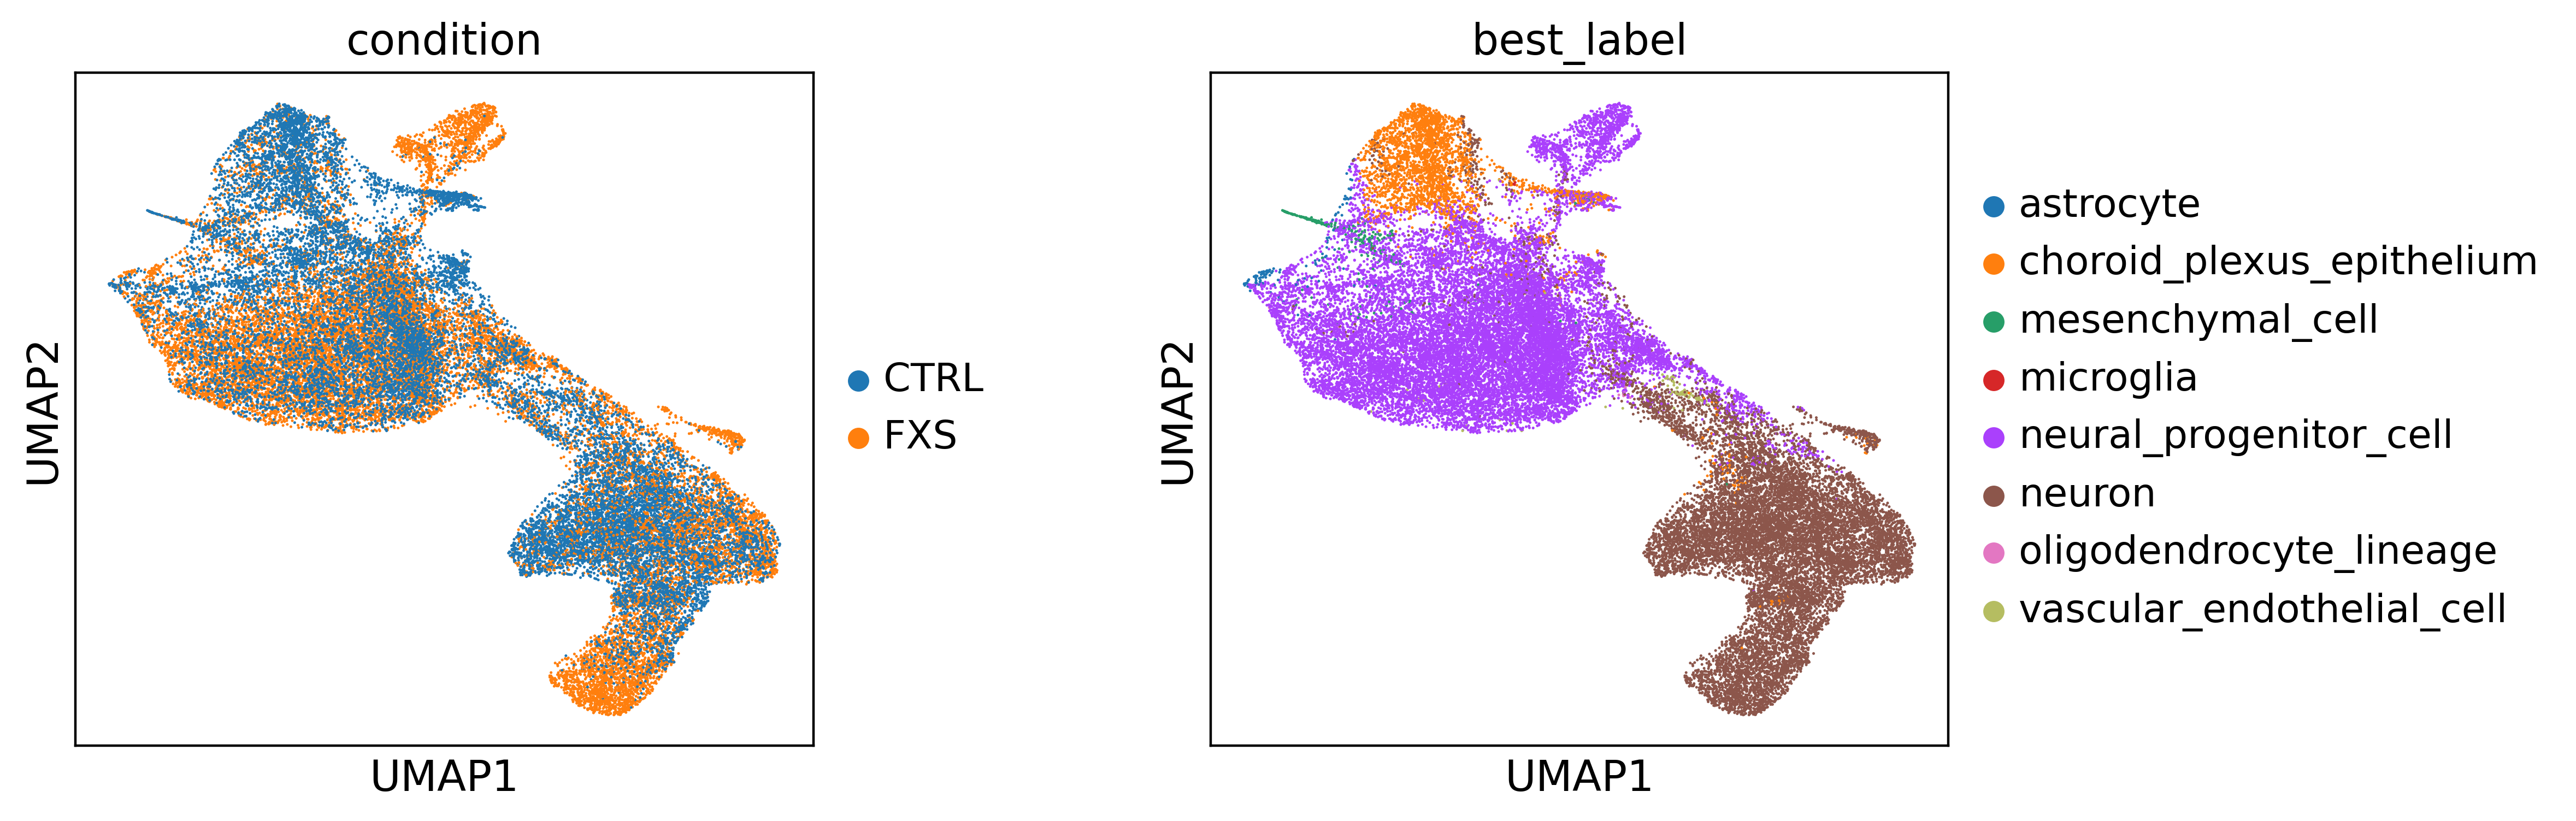

In [7]:
X_latent = mapper.get_latent_representation(query_adata)
query_adata.obsm["X_latent"] = X_latent
query_adata.obs["best_label"] = ct_transfer["best_label"]

sc.pp.neighbors(query_adata, use_rep="X_latent", method="rapids")
sc.tl.umap(query_adata, min_dist=0.3, method="rapids")
sc.pl.umap(query_adata, color=["condition", "best_label"], wspace=0.4)

Looks quite good! Now we can quantify the difference between the FXS dataset and the HNOCA. For this, we first use the wkNN graph to find matched (meta-)cells for each cell in the FXS dataset. Then we perform a differential expression analysis between the matched HNOCA cells and the query using an F-test.

In [8]:
matched_adata = mapper.get_matched_expression()
matched_adata

AnnData object with n_obs × n_vars = 36557 × 3000
    obs: 'sample', 'age', 'sex', 'disease', 'condition', 'publication', 'sc_method', 'batch_in_data', '_scvi_batch', '_scvi_labels', 'snapseed_level_1', 'snapseed_level_2', 'snapseed_level_3', 'snapseed_level_4', 'snapseed_level_5', 'snapseed_level_1_final', 'snapseed_level_2_final', 'snapseed_level_3_final', 'snapseed_level_4_final', 'snapseed_level_5_final', 'conditions_combined', 'annot_level_1', 'annot_level_2', 'annot_level_3', 'annot_level_4', 'annot_region', 'CellClass', 'Subregion', 'SummarizedRegion', 'NeurotransmitterTransporter', 'CellType', 'annot_region_rev', 'SummarizedRegion_hier', 'annot_region_rev2', 'annot_level_1_plus', 'annot_level_2_plus', 'annot_level_3_plus', 'annot_level_4_plus', 'annot_region_plus', 'annot_region_rev_plus', 'annot_region_rev2_plus', 'pearsonr_HNOCA_matched', 'is_control', 'avgdist_HNOCA_matched', 'pearsonr_HNOCA_matched_mtl', 'full_sample', 'nFeatures', 'louvain', 'louvain_1', 'batch', 'snapseed

In [9]:
paired_de = stats.test_de_paired(
    query_adata,
    matched_adata,
    num_threads=4,
    var_names=query_adata.var_names,
    adjust_method="holm",
)
paired_de

,f,coef,pval,padj
A2M,1.005743,-0.010660,5.840427e-01,1.000000e+00
ACTA2,1.005277,-0.019927,6.148829e-01,1.000000e+00
ACTC1,1.004356,-0.020906,6.777461e-01,1.000000e+00
ACTN2,1.012864,-0.019045,2.217502e-01,1.000000e+00
ADCYAP1,1.073479,-0.076012,1.221778e-11,4.398402e-09
...,...,...,...,...
ZIC1,1.182211,-0.311655,2.220446e-16,1.172396e-13
ZIC2,1.003396,-0.041030,7.458421e-01,1.000000e+00
ZIC4,1.150357,-0.153911,2.220446e-16,1.172396e-13
ZNF503,1.013888,0.077502,1.873387e-01,1.000000e+00


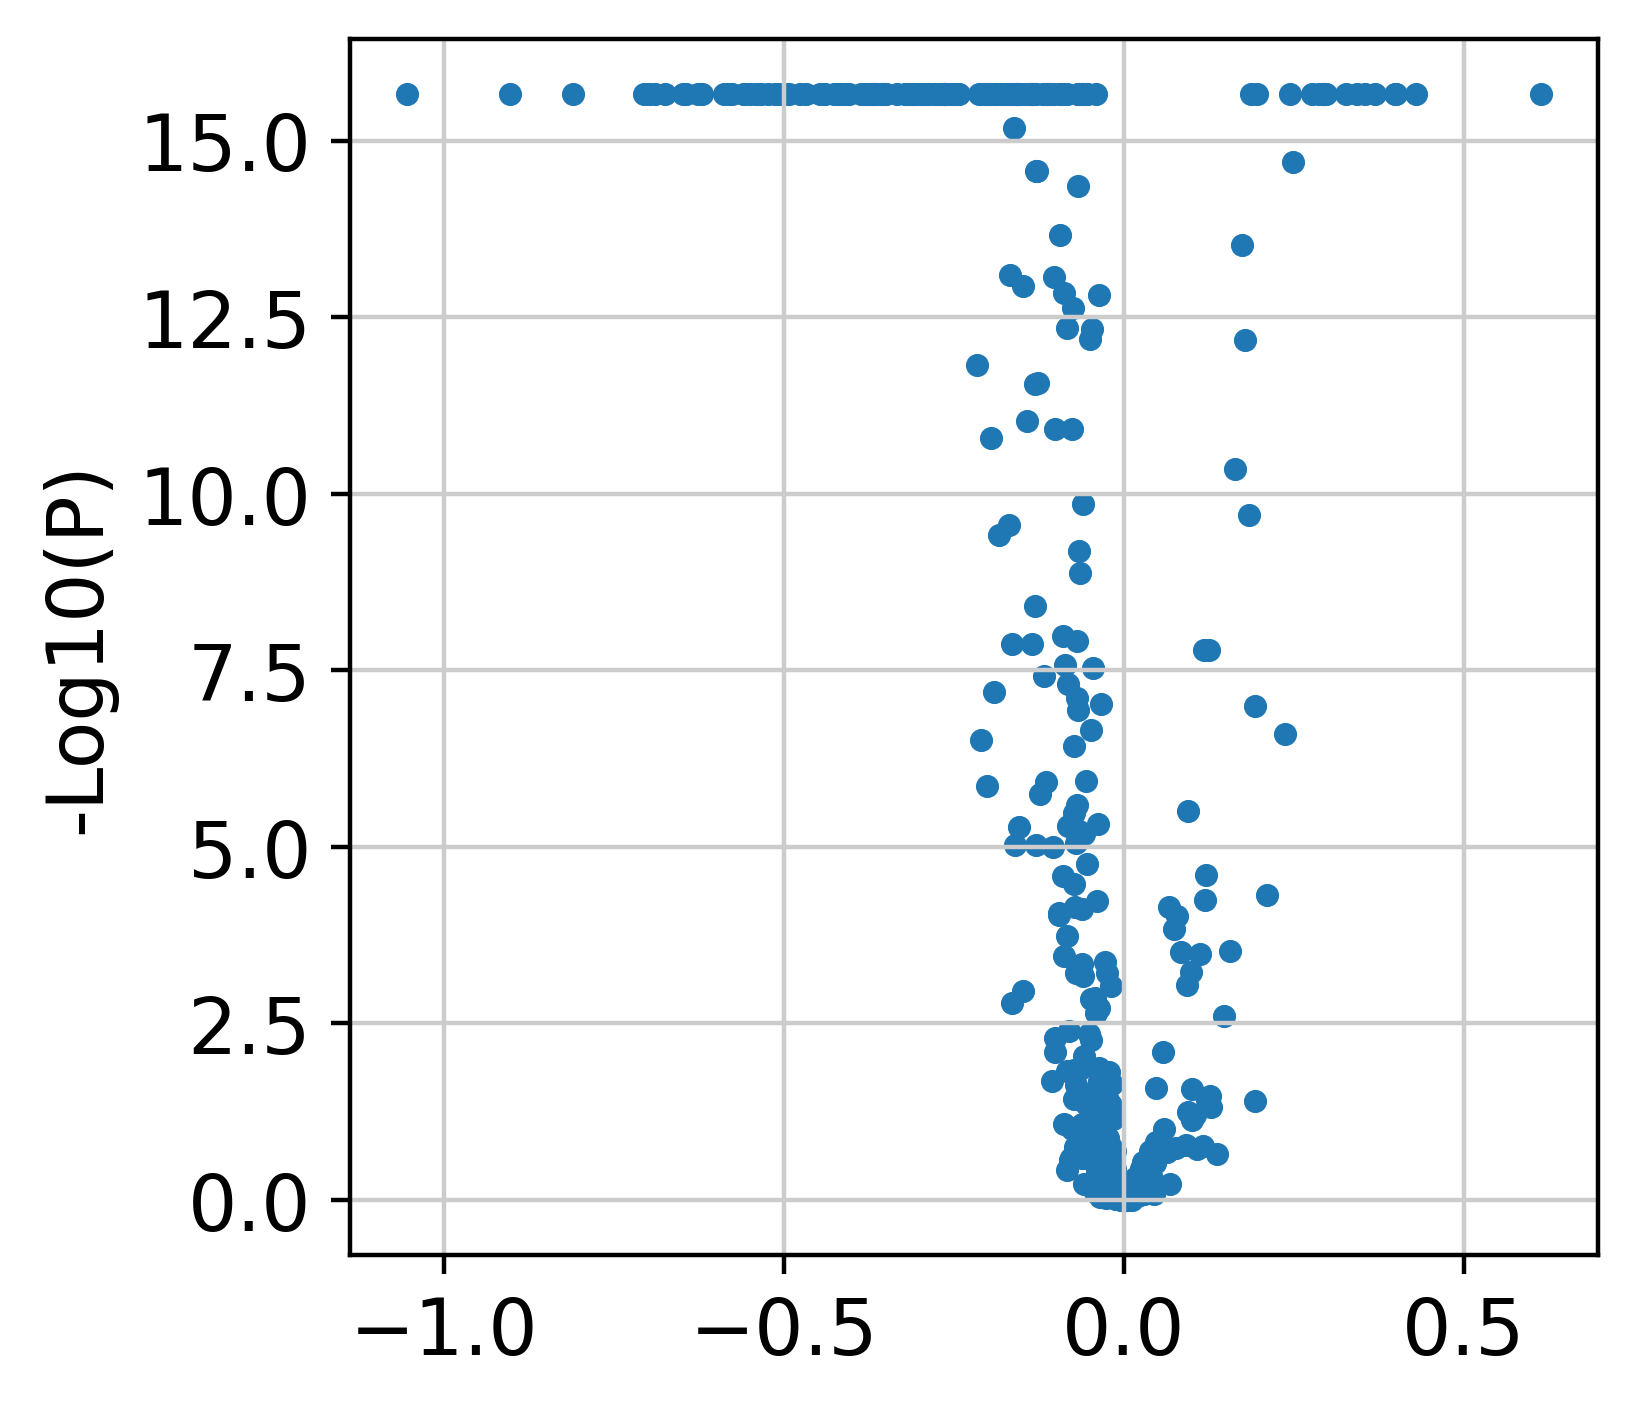

In [20]:
plt.scatter(paired_de['coef'], -np.log10(paired_de['pval']), s=10)
plt.ylabel('-Log10(P)')
plt.show()